# Data Exploration

In [1]:
import sys
import pickle
import re
import pandas as pd 
import numpy as np
import seaborn as sns
sys.path.append("../tools/")
import matplotlib.pyplot as plt
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from tester import test_classifier
from sklearn.feature_selection import SelectPercentile, SelectKBest
import warnings

/home/snaily/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

#converting data to pandas dataframe
data_df = pd.DataFrame.from_dict(data_dict, orient='index')
data_df.shape

(146, 21)

In [3]:
data_df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [4]:
data_df.count().sort_values()

salary                       146
long_term_incentive          146
deferred_income              146
director_fees                146
poi                          146
from_this_person_to_poi      146
other                        146
from_messages                146
loan_advances                146
email_address                146
expenses                     146
restricted_stock_deferred    146
shared_receipt_with_poi      146
restricted_stock             146
bonus                        146
exercised_stock_options      146
total_payments               146
deferral_payments            146
to_messages                  146
total_stock_value            146
from_poi_to_this_person      146
dtype: int64

The dataset is quite sparse with some variables like total_payments, total_stock_value having values for most of the employees, but some others like loan_advances, director_fees that have information for too few employees

Remove email_address field since we cannot use it somehow in the analysis and create a temporary copy without POI label

In [5]:
data_df = data_df.drop(['email_address'], axis = 1)
data_temp = data_df.drop(['poi'], axis=1)
data_temp[data_temp.isnull().all(axis=1)]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person


LOCKHART EUGENE E has all the values missing and shall be removed

In [6]:
data_df = data_df.drop(['LOCKHART EUGENE E'], axis=0)

In [7]:
#since some values are related
#rearrange the columns in the following order
cols = [
    'poi', 'salary', 'bonus', 'long_term_incentive', 'deferred_income',
    'deferral_payments', 'loan_advances', 'other', 'expenses', 'director_fees',
    'total_payments', 'exercised_stock_options', 'restricted_stock',
    'restricted_stock_deferred', 'total_stock_value',
    'from_poi_to_this_person', 'shared_receipt_with_poi', 'to_messages',
    'from_this_person_to_poi', 'from_messages'
]
data_df = data_df[cols]
data_df.head()

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_poi_to_this_person,shared_receipt_with_poi,to_messages,from_this_person_to_poi,from_messages
ALLEN PHILLIP K,False,201955,4175000,304805,-3081055,2869717,NaN,152,13868,NaN,4484442,1729541,126027,-126027,1729541,47,1407,2902,65,2195
BADUM JAMES P,False,NaN,NaN,NaN,NaN,178980,NaN,NaN,3486,NaN,182466,257817,NaN,NaN,257817,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,False,477,NaN,NaN,-5104,NaN,NaN,864523,56301,NaN,916197,4046157,1757552,-560222,5243487,39,465,566,0,29
BAXTER JOHN C,False,267102,1200000,1586055,-1386055,1295738,NaN,2660303,11200,NaN,5634343,6680544,3942714,NaN,10623258,NaN,NaN,NaN,NaN,NaN
BAY FRANKLIN R,False,239671,400000,NaN,-201641,260455,NaN,69,129142,NaN,827696,NaN,145796,-82782,63014,NaN,NaN,NaN,NaN,NaN


In [8]:
data_df.replace(to_replace="NaN", value=0, inplace=True)

In [9]:
#examine the statistics of the dataset
data_df.describe()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_poi_to_this_person,shared_receipt_with_poi,to_messages,from_this_person_to_poi,from_messages
count,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,145.000000,145.000000,145.000000,145.000000,145.000000
mean,3.683342e+05,1.342671e+06,6.692680e+05,-3.854019e+05,4.418227e+05,1.157586e+06,5.894693e+05,7.123619e+04,1.955643e+04,4.380626e+06,4.211583e+06,1.761321e+06,2.065786e+04,5.886335e+06,38.489655,697.765517,1230.013793,24.455172,361.075862
std,2.211001e+06,8.121319e+06,4.059716e+06,2.386279e+06,2.750583e+06,9.682311e+06,3.694784e+06,4.341759e+05,1.194559e+05,2.702539e+07,2.615843e+07,1.093676e+07,1.444650e+06,3.636916e+07,74.088359,1075.128126,2232.153003,79.527073,1445.944684
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.799289e+07,-1.025000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.604490e+06,-7.576788e+06,-4.409300e+04,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,-3.834600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.025000e+05,0.000000e+00,3.246000e+04,0.000000e+00,2.520550e+05,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.106920e+05,3.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.720000e+02,2.153000e+04,0.000000e+00,9.665220e+05,6.087500e+05,3.605280e+05,0.000000e+00,9.760370e+05,4.000000,114.000000,312.000000,0.000000,17.000000
75%,2.714420e+05,8.000000e+05,3.753040e+05,0.000000e+00,1.025900e+04,0.000000e+00,1.506560e+05,5.394700e+04,0.000000e+00,1.979596e+06,1.729541e+06,8.530640e+05,0.000000e+00,2.332399e+06,41.000000,900.000000,1607.000000,14.000000,52.000000
max,2.670423e+07,9.734362e+07,4.852193e+07,0.000000e+00,3.208340e+07,8.392500e+07,4.266759e+07,5.235198e+06,1.398517e+06,3.098866e+08,3.117640e+08,1.303223e+08,1.545629e+07,4.345095e+08,528.000000,5521.000000,15149.000000,609.000000,14368.000000


# Outlier Investigation

Seaborn's pairplot presents at same time the distribution of the variables and a scatter plot representation of them

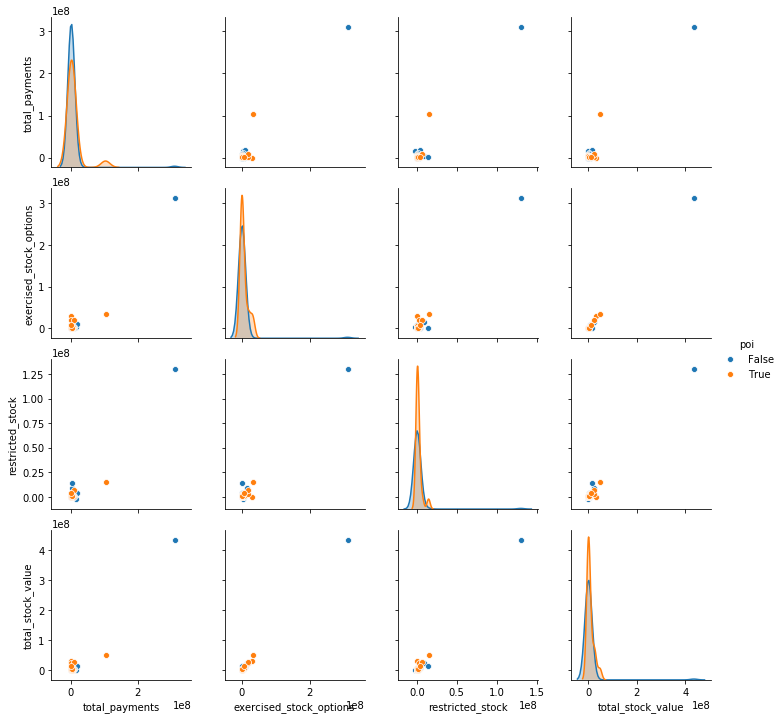

In [10]:
sns.pairplot(data=data_df, vars=['total_payments','exercised_stock_options', 'restricted_stock', 'total_stock_value'], hue='poi')
plt.show()

In [11]:
data_df.total_payments.nlargest(2)

TOTAL            309886585
LAY KENNETH L    103559793
Name: total_payments, dtype: int64

TOTAL is the totals on the enron61702insiderpay.pdf and not a person so it should be removed

In [12]:
data_df.drop('TOTAL', inplace=True)

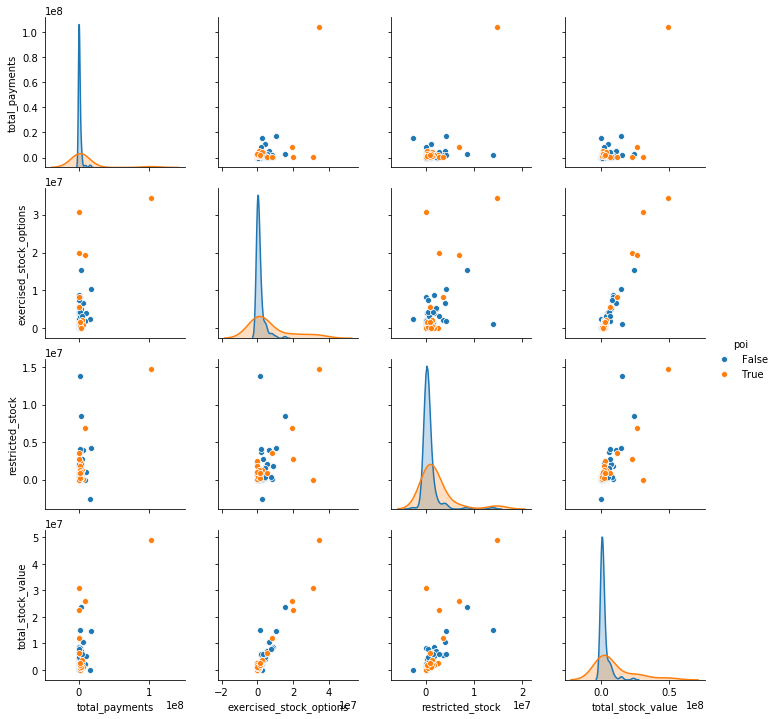

In [13]:
sns.pairplot(data=data_df, vars=["total_payments", "exercised_stock_options", "restricted_stock", "total_stock_value"], hue="poi")
plt.show()

After removing TOTAL we can see some trends in plots
restricted_stock variable indicates that more outliers may exist.
Since the data have been taken from a financial statement an error may have introduced during the data entry / scrapping.

We can make a first sanity by checking if the individual values sum with the totals of each category (Total Payments, Total Stock Value).

In [14]:
#sum of all payment variables
print(data_df.sum()[1:11])
print("-------------------------")
print("Sum all payment variables: ", sum(data_df.sum()[1:10]))

salary                  26704229.0
bonus                   97343619.0
long_term_incentive     48521928.0
deferred_income        -27890391.0
deferral_payments       31980896.0
loan_advances           83925000.0
other                   42805453.0
expenses                 5094049.0
director_fees            1437166.0
total_payments         325304226.0
dtype: float64
-------------------------
('Sum all payment variables: ', 309921949.0)


In [15]:
#sum of all stock variables
print(data_df.sum()[11:15])
print("----------------------------------")
print("Sum all stock variables: ", sum(data_df.sum()[11:14]))

exercised_stock_options      298915485.0
restricted_stock             125069226.0
restricted_stock_deferred     10572178.0
total_stock_value            419009128.0
dtype: float64
----------------------------------
('Sum all stock variables: ', 434556889.0)


The totals do not match, we need to check employee by employee to find the errors

In [16]:
errorlist = []
for line in data_df.itertuples():
    if sum(line[2:11]) != line[11] or sum(line[12:15]) != line[15]:
        errorlist.append(line[0])
data_df.loc[errorlist]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_poi_to_this_person,shared_receipt_with_poi,to_messages,from_this_person_to_poi,from_messages
BELFER ROBERT,False,0,0,0,0,-102500,0,0,0,3285,102500,3285,0,44093,-44093,0,0,0,0,0
BHATNAGAR SANJAY,False,0,0,0,0,0,0,137864,0,137864,15456290,2604490,-2604490,15456290,0,0,463,523,1,29


Comparing the above results with the enron61702insiderpay.pdf we can see that there are some errors in the data

In [17]:
data_df.loc["BELFER ROBERT", :] = [
    False, 0, 0, 0, -102500, 0, 0, 0, 3285, 102500, 3285, 0, 44093, -44093, 0,
    0, 0, 0, 0, 0
]
data_df.loc["BHATNAGAR SANJAY", :] = [
    False, 0, 0, 0, 0, 0, 0, 0, 137864, 0, 137864, 15456290, 2604490, -2604490,
    15456290, 0, 463, 523, 1, 29
]

In [18]:
data_df.loc[errorlist]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_poi_to_this_person,shared_receipt_with_poi,to_messages,from_this_person_to_poi,from_messages
BELFER ROBERT,False,0,0,0,-102500,0,0,0,3285,102500,3285,0,44093,-44093,0,0,0,0,0,0
BHATNAGAR SANJAY,False,0,0,0,0,0,0,0,137864,0,137864,15456290,2604490,-2604490,15456290,0,463,523,1,29


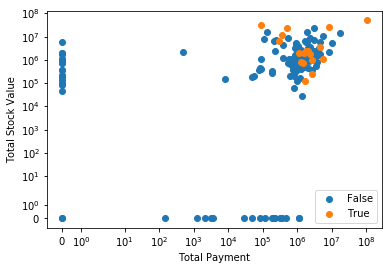

In [19]:
#plot the two aggregated varibles Total payments and Total Stock value
fig1, ax = plt.subplots()
for poi, data in data_df.groupby(by='poi'):
    ax.plot(data['total_payments'], data['total_stock_value'],'o', label=poi)
ax.legend()
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel('Total Payment')
plt.ylabel('Total Stock Value')
plt.show()

We can see that there are some persons with zero salary or bonus (or both) and none of them is a POI. Since we have a sparse number of POIs it might be beneficial to remove them to have a more dense dataset

In [20]:
data_nbs = data_df[data_df.salary > 0]
data_nbs = data_nbs[data_nbs.bonus > 0]
data_nbs.shape

(81, 20)

In [21]:
#check for more false entries like TOTAL
for index in data_df.index:
    if re.match('^[A-Z]+\s[A-Z]+(\s[A-Z])?$', index):
        continue
    else:
        print(index)

BLAKE JR. NORMAN P
BOWEN JR RAYMOND M
DERRICK JR. JAMES V
DONAHUE JR JEFFREY M
GARLAND C KEVIN
GLISAN JR BEN F
OVERDYKE JR JERE C
PEREIRA PAULO V. FERRAZ
SULLIVAN-SHAKLOVITZ COLLEEN
THE TRAVEL AGENCY IN THE PARK
WALLS JR ROBERT H
WHITE JR THOMAS E
WINOKUR JR. HERBERT S
YEAGER F SCOTT


THE TRAVEL AGENCY IN THE PARK isn't a name of an employee

In [22]:
data_df.loc[['THE TRAVEL AGENCY IN THE PARK']]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,from_poi_to_this_person,shared_receipt_with_poi,to_messages,from_this_person_to_poi,from_messages
THE TRAVEL AGENCY IN THE PARK,False,0,0,0,0,0,0,362096,0,0,362096,0,0,0,0,0,0,0,0,0


In [23]:
data_df = data_df.drop(['THE TRAVEL AGENCY IN THE PARK'], axis=0)

As a final step in outlier investigation, we will search for extreme values as they are essential information. They should be kept but let's spot them first.

In [24]:
#using Tukey Fences with 3 IQRs for every single feature

def outlier_iqr(data, features):
    result = set()
    for feature in features:
        ys = data[[feature]]
        q1, q3 = np.percentile(ys, [25,75])
        iqr = q3 - q1
        lb = int(round(q1 - (iqr*3)))
        ub = int(round(q3 + (iqr*3)))
        partial_result = list(np.where((ys > ub) | (ys < lb))[0])
        print feature, len(partial_result)
        result.update(partial_result)
        
    print("-------------------------------------------------------------")
    print "Total number of records with extreme values: ", len(result)
    
    return list(result)

In [25]:
cols.remove('poi')
xtr_values = outlier_iqr(data_df, cols)

salary 1
bonus 5
long_term_incentive 11
deferred_income 24
deferral_payments 33
loan_advances 3
other 13
expenses 2
director_fees 15
total_payments 5
exercised_stock_options 11
restricted_stock 9
restricted_stock_deferred 17
total_stock_value 11
from_poi_to_this_person 11
shared_receipt_with_poi 4
to_messages 6
from_this_person_to_poi 13
from_messages 20
-------------------------------------------------------------
Total number of records with extreme values:  93


Among this extreme values we will check how many among them are POI's

In [26]:
p = data_df.loc[:, 'poi'].value_counts()
poi_density = p[1] /float(p[0] + p[1])
print "POI density on the original dataset: ", poi_density
p = data_df.ix[xtr_values, 'poi'].value_counts()
poi_density_xtr = p[1]/float(p[0]+p[1])
print "POI density on the subset with the extreme values: ", poi_density_xtr
print "Difference: ", (poi_density_xtr-poi_density) / float(poi_density)

POI density on the original dataset:  0.125874125874
POI density on the subset with the extreme values:  0.161290322581
Difference:  0.281362007168


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


There are 28% more POIs than in the general dataset.
Thus the extreme values are related with being a POI, thus we will not remove them

Now that the dataset is clear of outliers we can find the final dimensions and split the labels from the features and have a first scoring as a baseline for the rest of the analysis.

In [27]:
data_df.shape

(143, 20)

In [28]:
#split data in labels and features
def do_split(data):
    X = data.copy()
    y = X.pop('poi').astype(int)
    
    return X, y

We will use the GaussianNB classifier to begin 

In [29]:
f = data_df.columns.tolist()
d = data_df.to_dict(orient='index')
test_classifier(GaussianNB(), d,f)

GaussianNB(priors=None)
	Accuracy: 0.76353	Precision: 0.24564	Recall: 0.37350	F1: 0.29637	F2: 0.33828
	Total predictions: 15000	True positives:  747	False positives: 2294	False negatives: 1253	True negatives: 10706



# Optimize Feature Selection/Engineering

Add the proportions of each variable to its category's sum

In [30]:
data = data_df.copy()
data.loc[:, "salary_p"] = data.loc[:, "salary"]/data.loc[:, "total_payments"]
data.loc[:, "deferral_payments_p"] = data.loc[:, "deferral_payments"]/data.loc[:, "total_payments"]
data.loc[:, "loan_advances_p"] = data.loc[:, "loan_advances"]/data.loc[:, "total_payments"]
data.loc[:, "bonus_p"] = data.loc[:, "bonus"]/data.loc[:, "total_payments"]
data.loc[:, "deferred_income_p"] = data.loc[:, "deferred_income"]/data.loc[:, "total_payments"]
data.loc[:, "expenses_p"] = data.loc[:, "expenses"]/data.loc[:, "total_payments"]
data.loc[:, "other_p"] = data.loc[:, "other"]/data.loc[:, "total_payments"]
data.loc[:, "long_term_incentive_p"] = data.loc[:, "long_term_incentive"]/data.loc[:, "total_payments"]
data.loc[:, "director_fees_p"] = data.loc[:, "director_fees"]/data.loc[:, "total_payments"]

data.loc[:, "restricted_stock_deferred_p"] = data.loc[:, "restricted_stock_deferred"]/data.loc[:, "total_stock_value"]
data.loc[:, "exercised_stock_options_p"] = data.loc[:, "exercised_stock_options"]/data.loc[:, "total_stock_value"]
data.loc[:, "restricted_stock_p"] = data.loc[:, "restricted_stock"]/data.loc[:, "total_stock_value"]

data.loc[:, "from_poi_to_this_person_p"] = data.loc[:, "from_poi_to_this_person"]/data.loc[:, "to_messages"]
data.loc[:, "shared_receipt_with_poi_p"] = data.loc[:, "shared_receipt_with_poi"]/data.loc[:, "to_messages"]

data.loc[:, "from_this_person_to_poi_p"] = data.loc[:, "from_this_person_to_poi"]/data.loc[:, "from_messages"]
    
data.replace(to_replace=np.NaN, value=0, inplace=True)
data.replace(to_replace=np.inf, value=0, inplace=True)
data.replace(to_replace=-np.inf, value=0, inplace=True)

In [31]:
#plot the importance of features of the dataset by using same classifier

def plot_importance(dataset):
    X, y = do_split(dataset)
    
    selector = SelectPercentile(percentile = 100)
    a = selector.fit(X,y)
    
    plt.figure(figsize=(12,9))
    sns.barplot(y=X.columns, x=a.scores_)
    plt.show()

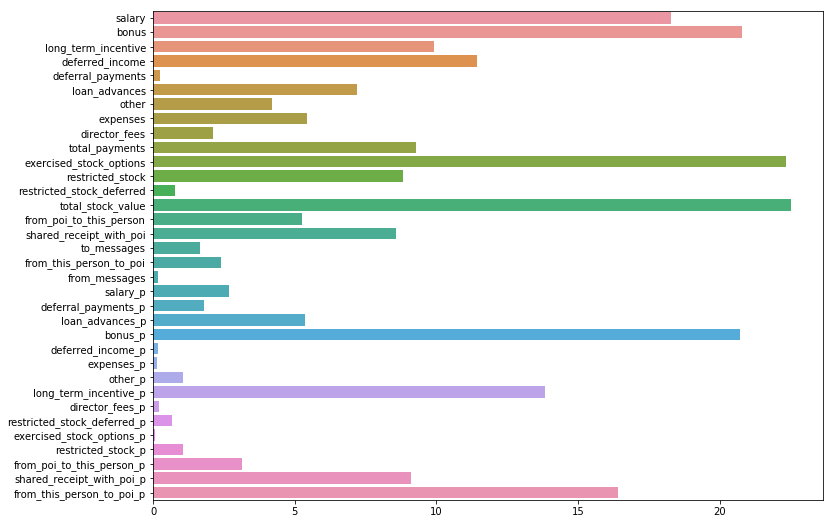

In [32]:
plot_importance(data)

Comparing the newly created features with the original we can see that the proportions of “Long Term Incentive”, “Restricted Stock Deferred” and “From This Person to POI” score higher than the original features. We will keep these and remove the original values. to avoid bias the model towards a specific feature by using both the original value and its proportion.

In [33]:
#Adding the proportions
data_df.loc[:, "long_term_incentive_p"] = data_df.loc[:, "long_term_incentive"]/data_df.loc[:, "total_payments"]
data_df.loc[:, "restricted_stock_deferred_p"] = data_df.loc[:, "restricted_stock_deferred"]/data_df.loc[:, "total_stock_value"]
data_df.loc[:, "from_this_person_to_poi_p"] = data_df.loc[:, "from_this_person_to_poi"]/data_df.loc[:, "from_messages"]
#Removing the original values.
data_df.drop("long_term_incentive", axis=1)
data_df.drop("restricted_stock_deferred", axis=1)
data_df.drop("from_this_person_to_poi", axis=1)
#Correcting NaN and infinity values created by zero divisions
data_df.replace(to_replace=np.NaN, value=0, inplace=True)
data_df.replace(to_replace=np.inf, value=0, inplace=True)
data_df.replace(to_replace=-np.inf, value=0, inplace=True)

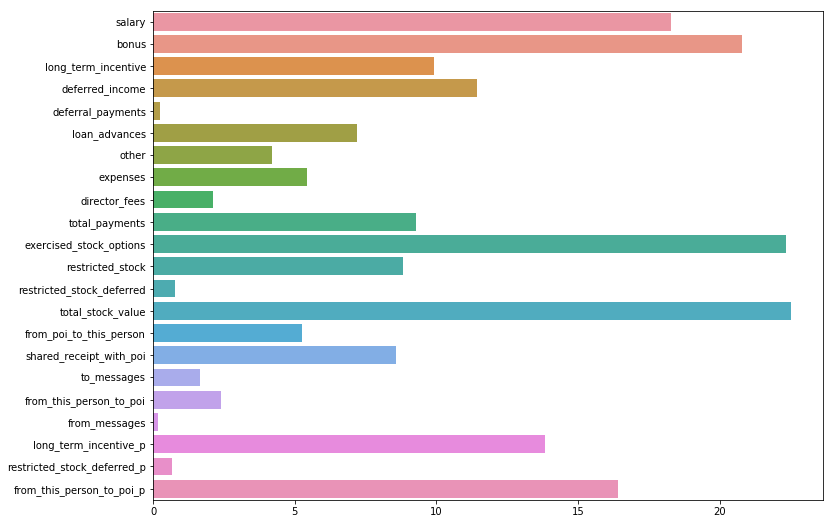

In [34]:
plot_importance(data_df)

# Feature Selection

We will use GaussianNB classifier and will test univariate feature selection (KBest) and Primary component analysis (PCA).
There are features in dataset with big differences in scaling. Some of the algorithm we will evaluate may behave badly because of these differences so we need to scale them.
We will use MaxAbsScaler() for this.

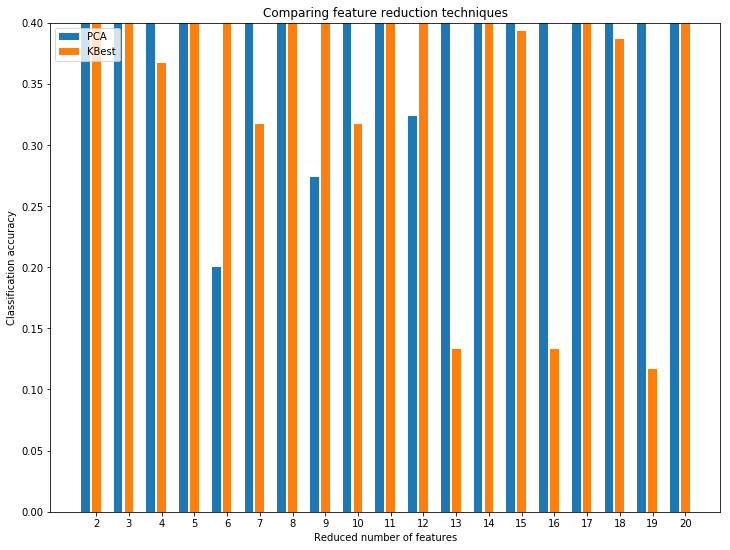

Pipeline(memory=None,
     steps=[('scale', None), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=7, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', GaussianNB(priors=None))])

In [35]:
warnings.filterwarnings('ignore')

pipe = Pipeline([('scale', MaxAbsScaler()),
                 ('reduce_dim', PCA(random_state=42)),
                 ('classify', GaussianNB())])

N_FEATURES_OPTIONS = list(range(2,21))

param_grid = [
    {
        'scale':[None, MaxAbsScaler(), StandardScaler()],
        'reduce_dim': [PCA(random_state=42)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
        'scale':[None, MaxAbsScaler(), StandardScaler()],
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
    },
]
reducer_labels = ['PCA', 'KBest']
cv = StratifiedShuffleSplit(random_state=42)
grid = GridSearchCV(
    pipe, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)

X, y = do_split(data_df)
grid.fit(X, y)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)
plt.figure(figsize=(12,9))

for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label)

plt.title('Comparing feature reduction techniques')
plt.xlabel('Reduced number of features')
plt.ylabel('Classification accuracy')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylim((0, 0.4))
plt.legend(loc='upper left')

plt.show()
grid.best_estimator_

We get the best results if we reduce the features of the model to:

In [36]:
selector = SelectKBest(k=6)
selector.fit(X,y)
X.columns[selector.get_support()].tolist()

['salary',
 'bonus',
 'exercised_stock_options',
 'total_stock_value',
 'long_term_incentive_p',
 'from_this_person_to_poi_p']

The score of GaussianNB on the reduced dataset is: 

In [37]:
features = data_df.columns.tolist()
data_dict = data_df.to_dict(orient='index')
test_classifier(grid.best_estimator_, data_dict, features)

Pipeline(memory=None,
     steps=[('scale', None), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=7, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', GaussianNB(priors=None))])
	Accuracy: 0.84840	Precision: 0.41595	Recall: 0.33900	F1: 0.37355	F2: 0.35202
	Total predictions: 15000	True positives:  678	False positives:  952	False negatives: 1322	True negatives: 12048



There is improvement on the f1 score, precision and recall

# Algorithm Selection and Tuning

Having finished with the preprocessing of the dataset, we will begin evaluating the performance of suitable algorithms.

## Algorithm Family Selection

### Support Vector Machine

From SVM we will evaluate support vector classifier (SVC) with default kernel (RBF) and penaly parameters 0.1,1,10

In [38]:
pipe = Pipeline([('scale', MaxAbsScaler()),
                 ('reduce_dim', PCA(random_state=42)),
                 ('classify', SVC(random_state=42))])

N_FEATURES_OPTIONS = list(range(2, 10))
C_VALUES = [0.1, 1, 10]


param_grid = [
    {
        'scale':[None, MaxAbsScaler()],
        'reduce_dim': [PCA(random_state=42)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_VALUES
    },
    {
        'scale':[None, MaxAbsScaler()],
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_VALUES
    },
]

cv = StratifiedShuffleSplit(random_state=42)
grid = GridSearchCV(
    pipe, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)

grid.fit(X, y)

print(grid.best_estimator_)

Pipeline(memory=None,
     steps=[('scale', MaxAbsScaler(copy=True)), ('reduce_dim', SelectKBest(k=5, score_func=<function f_classif at 0x7f21ed0155f0>)), ('classify', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


In [39]:
test_classifier(grid.best_estimator_, data_dict, features)

Pipeline(memory=None,
     steps=[('scale', MaxAbsScaler(copy=True)), ('reduce_dim', SelectKBest(k=5, score_func=<function f_classif at 0x7f21ed0155f0>)), ('classify', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.86320	Precision: 0.39431	Recall: 0.04850	F1: 0.08638	F2: 0.05882
	Total predictions: 15000	True positives:   97	False positives:  149	False negatives: 1903	True negatives: 12851



SVC has better accuracy than GaussianNB but at same time the worst Recall achieving and F1 score of 0.08632

### Nearest Neighbors

From the Nearest Neighbors family, we will evaluate KNeighborsClassifier.

In [40]:
pipe = Pipeline([('scale', MaxAbsScaler()),
                 ('reduce_dim', PCA(random_state=42)),
                 ('classify', KNeighborsClassifier())])

N_FEATURES_OPTIONS = list(range(2, 10))
N_NEIGHBORS = [1,3,5]


param_grid = [
    {
        'scale':[None, MaxAbsScaler()],
        'reduce_dim': [PCA(random_state=42)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__weights': ['uniform', 'distance'],
        'classify__n_neighbors': N_NEIGHBORS,
        'classify__p': [1,2]
    },
    {
        'scale':[None, MaxAbsScaler()],
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__weights': ['uniform', 'distance'],
        'classify__n_neighbors': N_NEIGHBORS,
        'classify__p': [1,2]
    },
]

cv = StratifiedShuffleSplit(random_state=42)
grid = GridSearchCV(
    pipe, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)

grid.fit(X, y)

print(grid.best_estimator_)

Pipeline(memory=None,
     steps=[('scale', MaxAbsScaler(copy=True)), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=1,
           weights='distance'))])


In [41]:
test_classifier(grid.best_estimator_, data_dict, features)

Pipeline(memory=None,
     steps=[('scale', MaxAbsScaler(copy=True)), ('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=1,
           weights='distance'))])
	Accuracy: 0.84920	Precision: 0.38726	Recall: 0.22500	F1: 0.28463	F2: 0.24558
	Total predictions: 15000	True positives:  450	False positives:  712	False negatives: 1550	True negatives: 12288



KneighborsClassifier has the balanced result across Precision and Recall.

### Ensemble Methods

In ensemble methods, we will evaluate both Random Forest and AdaBoost

#### Random Forest 

In [ ]:
pipe = Pipeline([('reduce_dim', PCA(random_state=42)),
                 ('classify', RandomForestClassifier(random_state=42))])

N_FEATURES_OPTIONS = list(range(2, 21))
N_TREES = [1,2,3]


param_grid = [
    {
        'reduce_dim': [PCA(random_state=42)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__n_estimators': N_TREES,
        'classify__criterion': ["gini", "entropy"]
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__n_estimators': N_TREES,
        'classify__criterion': ["gini", "entropy"]
    },
]

cv = StratifiedShuffleSplit(random_state=42)
grid = GridSearchCV(
    pipe, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)

grid.fit(X, y)

test_classifier(grid.best_estimator_, data_dict, features)

Pipeline(memory=None,
     steps=[('reduce_dim', SelectKBest(k=8, score_func=<function f_classif at 0x7f21ed0155f0>)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impuri...estimators=1, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])
	Accuracy: 0.81080	Precision: 0.29008	Recall: 0.28950	F1: 0.28979	F2: 0.28962
	Total predictions: 15000	True positives:  579	False positives: 1417	False negatives: 1421	True negatives: 11583



Random Forest also has a balanced behavior but the accuracy score is lower compared to KNN

#### AdaBoost 

In [ ]:
pipe = Pipeline([('reduce_dim', PCA(random_state=42)),
                 ('classify', AdaBoostClassifier(random_state=42))])

N_FEATURES_OPTIONS = list(range(2, 21))
N_ESTIMATORS = [1,10,100]


param_grid = [
    {
        'reduce_dim': [PCA(random_state=42)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__n_estimators': N_ESTIMATORS,
        'classify__algorithm': ['SAMME', 'SAMME.R']
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__n_estimators': N_ESTIMATORS,
        'classify__algorithm': ['SAMME', 'SAMME.R']
    },
]

cv = StratifiedShuffleSplit(random_state=42)
grid = GridSearchCV(
    pipe, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)

grid.fit(X, y)

test_classifier(grid.best_estimator_, data_dict, features)

## Decision Tree

In [ ]:
pipe = Pipeline([('reduce_dim', PCA(random_state=42)),
                 ('classify', DecisionTreeClassifier(random_state=42))])

N_FEATURES_OPTIONS = list(range(2, 21))



param_grid = [
    {
        'reduce_dim': [PCA(random_state=42)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__criterion': ["gini", "entropy"]
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__criterion': ["gini", "entropy"]
    },
]

cv = StratifiedShuffleSplit(random_state=42)
grid = GridSearchCV(
    pipe, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)

grid.fit(X, y)

test_classifier(grid.best_estimator_, data_dict, features)

## Algorithm Selection

K-Nearest Neighbor's performance is quite strong and we can safely conclude that it is the best classifier in this case.

Accuracy: 0.84920	Precision: 0.38726	Recall: 0.22500	F1: 0.28463	F2: 0.24558
Total predictions: 15000	True positives:  450	False positives:  712	False negatives: 1550	True negatives:12288

In [ ]:
scale = MaxAbsScaler()
X_trans = scale.fit_transform(X)
pca = PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

X_trans = pca.fit_transform(X_trans)
y_trans = y.values

clf = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=1,
           weights='distance')
clf.fit(X_trans,y_trans)

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
h = .02  #step size in the mesh

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_trans[:, 0].min() - 0.1, X_trans[:, 0].max() + 0.1
y_min, y_max = X_trans[:, 1].min() - 0.1, X_trans[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot the training points
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=y_trans, cmap=cmap_bold, alpha=0.3)

# Legend Data
classes = ['POI','Non-POI']
class_colours = ['#0000FF', '#FF0000']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

# Plot Legend ('loc' == position):
plt.legend(recs,classes,loc=4)

plt.title("KNN classifier with minkowski metric")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

plt.show()
fig.savefig('knn.png')

# Project Closure

## Dumping files 

In [ ]:
dump_classifier_and_data(clf, data_dict, features)

In [ ]:
import tester
tester.main()